In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import norm
import scipy.integrate as integrate

In [ ]:
np.random.seed(2)

In [88]:
# Generate data
size = 100
mu = np.random.normal(0,1,size=size)
#mu = np.random.uniform(-1,1,size)
sigma = 1
X = np.random.normal(mu,sigma)
#X = np.random.uniform(-1,1,size)

In [89]:
# Calculate joint posterior distribution
def prior_mu(mu):
    density = norm.pdf(mu, loc=0, scale=1)
    return density

def likelihood_x(x,mu):
    density = norm.pdf(x, loc=mu, scale=1)
    return density

def likelihood_X(X,mu):
    res = 1
    for point in X:
        res *= likelihood_x(point,mu)
    return res

#def likelihood_times_prior_mu(X,mu):
#    return likelihood_X(X,mu) * prior_mu(mu)

#def prior_X(X):
#    res = integrate.quad(lambda mu: likelihood_times_prior_mu(X,mu),a=-np.inf,b=np.inf)[0]
#    return res

#def joint_posterior(x,mu,X):
#    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
#    return res

def joint_posterior_without_normalizing_constant(x,mu,X):
    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu)
    return res

def posterior_marginal_x_without_normalizing_constant(x,X):
    res = integrate.quad(lambda mu:joint_posterior_without_normalizing_constant(mu=mu,X=X,x=x),a=-np.inf,b=np.inf)[0]
    return res

In [61]:
# Build grid for plotting

mu_plot = linspace(-2,2,50)
x_plot = linspace(-2,2,50)

grid = np.zeros((50,50))
X_coords = linspace(-1,1,50)
Y_coords = linspace(-4,4,50)

for index_i,i in enumerate(x_plot):
    for index_j,j in enumerate(mu_plot):
        grid[index_i,index_j] = joint_posterior_without_normalizing_constant(i,j,X)
        
#grid = [[joint_posterior_without_normalizing_constant(i,j,X) for index_j,j in enumerate(mu_plot)] for index_i,i in enumerate(x_plot)]

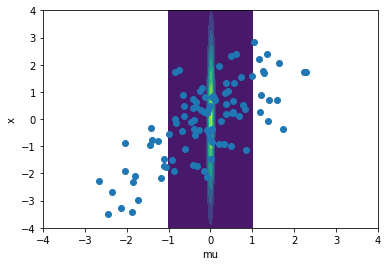

In [70]:
cnt = contourf(X_coords, Y_coords, grid)
plt.xlabel('mu')
plt.ylabel('x')
plt.ylim((-4,4))
plt.xlim((-4,4))
_ = plt.scatter(mu, X)

(array([  0.,   3.,   4.,  15.,  20.,  46.,  55.,  93., 133., 130., 134.,
        127.,  94.,  64.,  46.,  18.,   7.,   4.,   5.,   1.]),
 array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 20 Patch objects>)

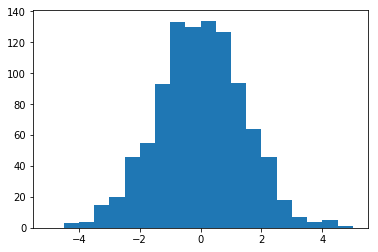

In [83]:
hist(X,range=[-5,5],bins=20)

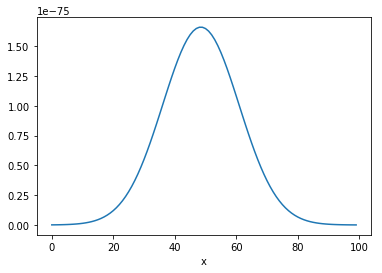

In [105]:
# Plot posterior marginal distribution of x

marginals=[]

for x in  np.linspace(-4,4,100):
    marginals.append(posterior_marginal_x_without_normalizing_constant(x,X))

plt.plot(marginals)

plt.show()

In [116]:
plot??